In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')

In [35]:
# read in all the words
words = open('makemore_dataset/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [52]:
# map each character to an index for one-hot encoding
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [39]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [109]:
g = torch.Generator(device=torch.device('cuda:0')).manual_seed(11)
n_embd = 10
n_hidden = 200

# vector embeddings
C = torch.randn((vocab_size, n_embd), generator=g)

# 3*10 incoming weights for 200 neurons
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01

# 200 incoming weights for 27 neurons
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.01

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print(sum([p.nelement() for p in parameters]))

11897


In [150]:
# decide on training, validation, or test inputs
X = Xtr
Y = Ytr

# hyperparameters
epoch = 2500
lrs = torch.linspace(-3, -3, epoch)
s_minibatch = 40

# track statistics
lossi = []

for i in range(epoch):

    # minibatch creation
    ix = torch.randint(0, X.shape[0], (s_minibatch, ), generator=g)

    # batch for X and Y
    Xb = X[ix]
    Yb = Y[ix]

    # forward pass
    emb = C[Xb]
    hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
      
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    hpreact = (hpreact - bnmeani) / bnstdi 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update parameters
    lr = 10 ** lrs[i]

    for p in [C, W1, b1, W2, b2]:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.item())

print(loss.item())



2.364614963531494


In [159]:
# 1 concatenated input consisting of <block_size> concatenated <n_embd> dimensional embedding vectors
emb.view(emb.shape[0], -1)[0].shape

torch.Size([30])

$x = [x1, x2, ..., xn] \in R^n$

In [161]:
# 1st hidden layer
W1.shape, b1.shape

(torch.Size([30, 200]), torch.Size([200]))

In [157]:
# output from first layer + activation function
h.shape

torch.Size([40, 200])

In [156]:
W2.shape

torch.Size([200, 27])

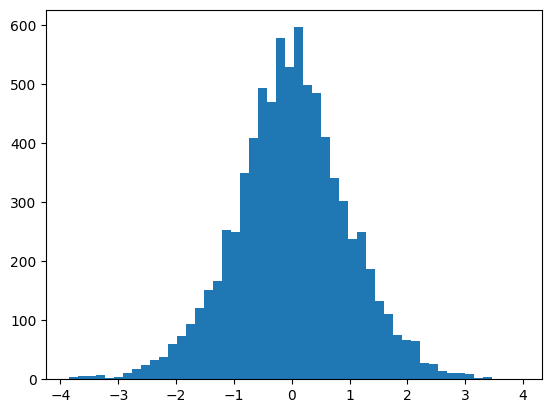

In [146]:
plt.hist(hpreact.view(-1).tolist(), 50);

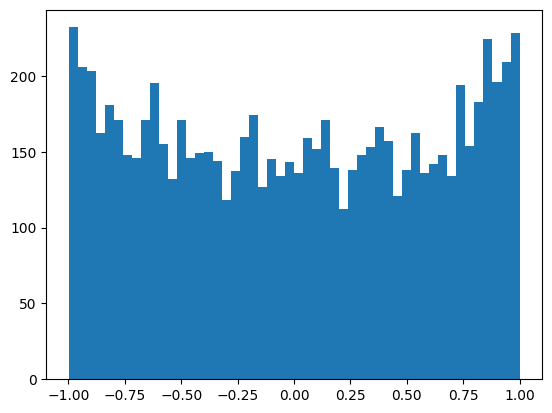

In [147]:
# information loss through oversaturated activation function tanh()
# looking at the derivative of tanh w.r.t any weight of the input, gradients are destroyed/ passed through
plt.hist(h.view(-1).tolist(), 50);

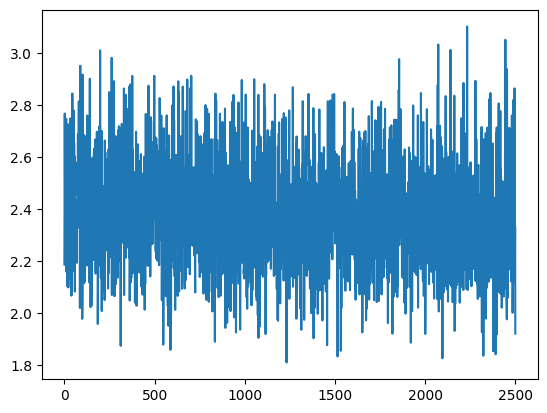

In [148]:
plt.plot(list(range(epoch)), lossi)

In [154]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
bnmean.shape, bnstd.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [132]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [149]:
# with batch normalising of initial loss and fixing saturated tanh
split_loss('train') # 2.24
split_loss('val') # 2.25

train 2.2832682132720947
val 2.288567066192627


In [51]:
# with standard forward pass
split_loss('train') # 2.077
split_loss('val') # 2.14

train 2.077878475189209
val 2.142366647720337


In [56]:
# sample from the model

# sampling 20 words
for _ in range(20):
    # array to store output indices
    out = []
    # start with empty context
    context =  [0] * block_size

    while True:
        # index into embedding vectors with each index in context
        vec = C[torch.tensor([context])]

        # pass concatenated embedding vectors through first hidden layer and activation function
        h = torch.tanh(vec.view(vec.shape[0], -1) @ W1 + b1) 

        # turn output logits into probability distribution
        logits = h @ W2 + b2 # (N, vocab_size)
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)

        # sample from indexed probability distribution for next index
        next_index = torch.multinomial(probs, num_samples=1, replacement=True).item()

        # update context window
        context = context[1:] + [next_index]
        out.append(next_index)
        
        # finish generation of word when stopping character is outputted
        if next_index == 0:
            break
    print(''.join(itos[i] for i in out))


graeden.
saan.
maree.
jaheem.
davianga.
coriousmahki.
camiarah.
maya.
montasymir.
kyson.
mereifyanni.
ashaansh.
keyonseden.
kaito.
remberneo.
isson.
liliphan.
aedyn.
canovan.
air.
